# 19 February summary: 

COHERENCE SCORE for 12 topics: 0.59 (highest coherence value)

|     Topic    |     Keywords                                                                                                                                                    |
|--------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     1        |     Tonight,   love, late, great, day, thing, world, chat, documentary, big night, spend,   outage, cool, thereidout, hear                                      |
|     2        |     Film, music,   project, currently looke, game animation, gl, visit http, rainsdowne players,   poster, the new, literally, artist, surprise, hire, light    |
|     3        |     Join, good,   year, set, lot, bad, movie, remake, put, boy, franchise, stuff, forget, speak,   icymi                                                        |
|     4        |     Podcast, time, listen, discuss, work, stream,   character, end, finally, issue, video, version, publish, meet, fun                                         |
|     5        |     Watch, live,   favorite, genre, bobcore, share, feel, tweet, honor, song, dark, follow,   episode, cast, line                                               |
|     6        |     Show, supergirl, young, dc_universe, original, pick,   season, tomorrow, full, enjoy, tune, game, ready, action, give                                   |
|     7        |    <b>Wandavision, release, spoiler, wanda_thevision, impact,   word, amazing, reveal, power, hope, cat, powerful_avenger, king, yup, scene    <b>                   |
|     8        |     Movie, make,   trailer, video, guest, uhg, skydance, cover, special, trustmovie, owen, hard,   support, art, great                                          |
|     9        |     Brand, today,   feature, back, drop, friend, send, people, long, link, break, couple, family,   expe, free                                                  |
|     10       |     Talk, accountability,   terrify, republicans_complain, find, life, big, night, start, play, story,   hit, flash, win, guy                                   |
|     11       |     Film, week,   amp, bring, wait, direct, business, job, support existe, mone, team,   goldfinger, adaptation, running man, call                              |


In this date we find wandavision as one of the most frequent words. The topic is well defined with the high-coherence number of topics of 11. Another topic that makes sense is the Topic.6 which is about the Supergirl show.

# **Topic modelling process for one batch of tweets**

Most of the code was provided by the lab session on the "Topic Modelling" lecture. However, there are some changes to adapt the procedure to our datasets. For example, we do a previous study on most and least frequent words.

This procedure cleans the text from the least used words, the usernames, the usual stopwords (with specific twitter words such as 'https','rt', and 'co') and the words that are directly from the search. It also creates and applies bigram and trigram models and lemmatizes the text. Finally, it applies and LDA Mallet Model, that together with a coherence study, returns the optimal number of topics and their keywords. We save the obtained topics.

Finally, to do some checking on the model we review the dominant topics in different tweets. 



## Import Packages and Data
The core packages used in this tutorial are **gensim**, and **pyLDAvis**. Besides this we will also using _re_, _matplotlib_, _numpy_ and _pandas_ for data handling and visualization. Let’s import them.

In [1]:
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import matplotlib.pyplot as plt 
from nltk.tokenize import RegexpTokenizer



# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.7MB 5.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=93861a7ec51088717191a39589b169c1e05adf3d6c1b777d5621e6ae07d07072
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Tweets collected from ['premiere','new movie','new episode', 'new film'] search

This is imported using _pandas.read_json_ 

In [75]:
# Import Dataset
with open('/content/drive/Shareddrives/WebIntelligence/DATA/Twitter/premiere19FEB.jsonl') as f:
    lines = f.read().splitlines()
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']    
df_inter['json_element'].apply(json.loads)
df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

# Keep only the tweets in English
df = df[df.lang=='en']

# Create URL field for tweets
df['url'] = 'https://twitter.com/_/status/'+df['id_str']

df.head(5)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,favorited,retweeted,filter_level,lang,timestamp_ms,user.id,user.id_str,user.name,user.screen_name,user.location,user.url,user.description,user.translator_type,user.protected,user.verified,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,user.created_at,user.utc_offset,user.time_zone,user.geo_enabled,user.lang,user.contributors_enabled,user.is_translator,user.profile_background_color,user.profile_background_image_url,user.profile_background_image_url_https,user.profile_background_tile,user.profile_link_color,user.profile_sidebar_border_color,user.profile_sidebar_fill_color,user.profile_text_color,user.profile_use_background_image,user.profile_image_url,user.profile_image_url_https,user.profile_banner_url,user.default_profile,user.default_profile_image,user.following,user.follow_request_sent,user.notifications,retweeted_status.created_at,retweeted_status.id,retweeted_status.id_str,retweeted_status.text,retweeted_status.display_text_range,retweeted_status.source,retweeted_status.truncated,retweeted_status.in_reply_to_status_id,retweeted_status.in_reply_to_status_id_str,retweeted_status.in_reply_to_user_id,retweeted_status.in_reply_to_user_id_str,retweeted_status.in_reply_to_screen_name,retweeted_status.user.id,retweeted_status.user.id_str,retweeted_status.user.name,retweeted_status.user.screen_name,retweeted_status.user.location,retweeted_status.user.url,retweeted_status.user.description,retweeted_status.user.translator_type,retweeted_status.user.protected,retweeted_status.user.verified,retweeted_status.user.followers_count,retweeted_status.user.friends_count,retweeted_status.user.listed_count,retweeted_status.user.favourites_count,retweeted_status.user.statuses_count,retweeted_status.user.created_at,retweeted_status.user.utc_offset,retweeted_status.user.time_zone,retweeted_status.user.geo_enabled,retweeted_status.user.lang,retweeted_status.user.contributors_enabled,retweeted_status.user.is_translator,retweeted_status.user.profile_background_color,retweeted_status.user.profile_background_image_url,retweeted_status.user.profile_background_image_url_https,retweeted_status.user.profile_background_tile,retweeted_status.user.profile_link_color,retweeted_status.user.profile_sidebar_border_color,retweeted_status.user.profile_sidebar_fill_color,retweeted_status.user.profile_text_color,retweeted_status.user.profile_use_background_image,retweeted_status.user.profile_image_url,retweeted_status.user.profile_image_url_https,retweeted_status.user.profile_banner_url,retweeted_status.user.default_profile,retweeted_status.user.default_profile_image,retweeted_status.user.following,retweeted_status.user.follow_request_sent,retweeted_status.user.notifications,retweeted_status.geo,retweeted_status.coordinates,retweeted_status.place,retweeted_status.contributors,retweeted_status.is_quote_status,retweeted_status.extended_tweet.full_text,retweeted_status.extended_tweet.display_text_range,retweeted_status.extended_tweet.entities.hashtags,retweeted_status.extended_tweet.entities.urls,retweeted_status.extended_tweet.entities.user_mentions,retweeted_status.extended_tweet.entities.symbols,retweeted_status.extended_tweet.entities.media,retweeted_status.extended_tweet.extended_entities.media,retweeted_status.quote_count,retweeted_status.reply_count,retweeted_status.retweet_count,retweeted_status.favorite_count,retweeted_status.entities.hashtags,retweeted_status.entities.urls,retweeted_status.entities.user_mentions,retweeted_status.entities.symbols,retweeted_status.favorited,retweeted_status.retweeted,retweeted_status.possibly_sensitive,retweeted_status.filter_level,retweeted_status.lang,entities.hashtags,entities.urls,entities.user_mentions,entities.s

In [76]:
# Convert to list
data = df.text.values.tolist()

# Remove users names
data = [re.sub('@[^\s]+', '', sent) for sent in data]

#Remove links
data = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',sent) for sent in data]

#Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]


pprint(data[:5])

["RT WARNING - SPOILERS BELOW: A brief frame during #WandaVision's new episode "
 "offered more insight into #SWORD's plan with #Th…",
 'RT New JJK episode had me sketching 😼 ',
 '#107DaysOfGenocide since joint forces of the #Ethiopian &amp; #Eritrean '
 'gov’ts started to exterminate ethnic Tigrayans… ',
 'RT The new documentary about the late, great Patrice O’Neal premieres '
 'tonight on Comedy Central. We went over some of his lesson…',
 'RT ALSO NEW EPISODE OF THE BOAT SHOW ']


## Study of most and least frequent words

Most frequent words contain the words we used for the search, as expected, the search words will be deleted from the search afterwards. However, in the most frequent words there is some relevant information and we shouln't delete all of them.

For the least frequent words we find non-sense expressions, mostly users names, that would mess up our topic modelling, so we delete the 100 less  used words.

7891
['new', 'episode', 'movie', 'film', 'wandavision', 'podcast', 'check', 'watch', 'amp', 'tonight']


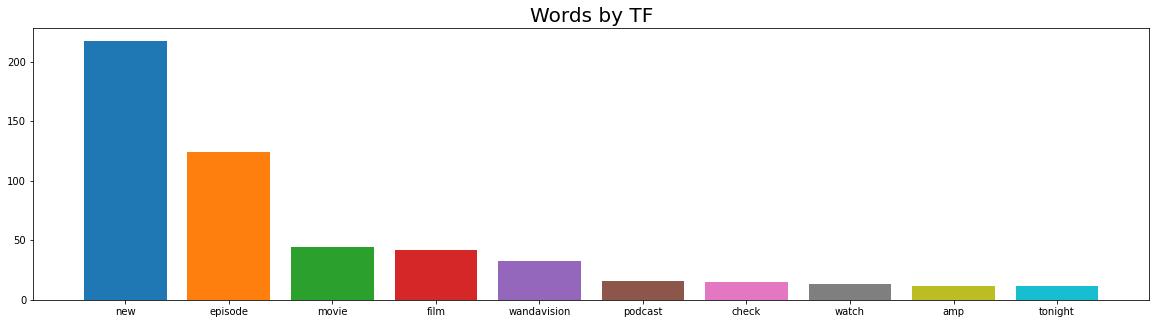

In [77]:
# Extract tokens, generate count vectors and remove stopwords
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

word_vec3 = df['text'].apply(str.lower).apply(tokenizer.tokenize).apply(pd.value_counts).fillna(0)

word_vec3 = word_vec3.drop(stopwords.words('english')+['https','co', 'rt'], axis=1, errors='ignore').fillna(0)
    
# Compute term frequencies
tf3 = word_vec3.divide(np.sum(word_vec3, axis=1), axis=0)

tf_dict3 = {}
for column in tf3:  
  tf_dict3[column] = tf3[column].sum()
print(len(tf_dict3))
tf_words3 = sorted(tf_dict3.items(), key=lambda item: item[1], reverse=True)[:10]
labels3  = [w[0] for w in tf_words3]
values3  = [w[1] for w in tf_words3]
indexes3 = np.arange(len(labels3))

print(labels3)

f3, ax3 = plt.subplots(figsize=(20,5))
cmap = plt.cm.tab10
plt.bar(indexes3, values3, color=cmap(np.arange(len(df)) % cmap.N))
plt.xticks(indexes3, labels3)
plt.title('Words by TF', fontsize=20)
plt.show()

In [78]:
tf_wordsless = sorted(tf_dict3.items(), key=lambda item: item[1], reverse=False)[:100]
labelsless  = [w[0] for w in tf_wordsless]
values3  = [w[1] for w in tf_wordsless]
indexes3 = np.arange(len(labelsless))

print('least frequent words',labelsless)


least frequent words ['dalmatians', 'themesnark', 'vgybnpq', 'mv', 'lyric', 'land', 'ryu', 'icons', 'mxtga', 'epic', 'eoiz', 'reichl', 'revops', 'prbc', 'saas', 'nimbly', 'plp', 'ber', 'teen', 'fd', 'backdrops', 'titans', 'named', 'lockdown', 'amadea', 'planet', 'jasonmanford', 'cornetto', 'spider', 'liked', 'pegg', 'fab', 'friendliest', 'heyo', 'ckvw', 'hav', 'costner', 'sela', 'kutcher', 'josephdemauro', 'ashton', 'ward', 'guardian', 'ww', 'nl', 'znlnbvhf', 'text', 'nouveau', 'placebo', 'jfc', 'somehow', 'iona', 'hsj', 'fpx', 'pagmyst', 'thecartooncrave', 'max', 'infinity', 'upfront', 'highlights', 'ahjmly', 'tears', 'electricjazzcat', 'vu', 'vmkw', 'soda', 'uo', 'fiizz', 'unbound', 'beasting', 'machine', 'washing', 'protex', 'wniqorudbc', 'degrees', 'aeg', 'lavamat', 'rinse', 'uvdywwmu', 'tah', 'mooh', 'lay', 'newcomer', 'pol', 'humpday', 'menatplaycom', 'rosso', 'leor', 'leo', 'prince', 'yvrshoots', 'vancouver', 'maclaine', 'dinklage', 'shirley', 'dreamer', 'indie', 'vjsks', 'azumi

# Preparation and clean-up for data

## Prepare Stopwords (different!)
We import the english stopwords and, together with least frequent words, the search words and other expressions, we make it available in stop_words.

In [79]:
# NLTK Stop words
stop_words = stopwords.words('english')

delete_words = []

#Search words
delete_words.append('new')
delete_words.append('episode')
delete_words.append('premiere')
delete_words.append('check')
delete_words.append('watch')

#least frequent words
delete_words_full = delete_words + labelsless

#other expressions
stop_words.extend(['rt', 'https', 'co'])
stop_words.extend(delete_words_full)

## Tokenize words and Clean-up text (from the lab)

Tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s _simple_preprocess()_ is great for this. Additionally I have set _deacc=True_ to remove the punctuations.

In [80]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['rt', 'warning', 'spoilers', 'below', 'brief', 'frame', 'during', 'wandavision', 'new', 'episode', 'offered', 'more', 'insight', 'into', 'sword', 'plan', 'with', 'th']]


## Creating Bigram and Trigram Models (from the lab)

Gensim’s _Phrases_ model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to _Phrases_ are _min_count_ and _threshold_. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [81]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print([g for g in trigram_mod[bigram_mod[data_words[0]]] if '_'  in g])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[]


## Remove Stopwords, Make Bigrams and Lemmatize (from the lab)

Definition of the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.



In [82]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [83]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

[['warning', 'wandavision', 'offer', 'insight', 'sword', 'plan'], [], ['eritrean_gov', 'ts_starte', 'exterminate_ethnic', 'tigrayan'], ['documentary', 'late', 'great', 'patrice', 'neal', 'premiere', 'tonight', 'comedy', 'central', 'go', 'lesson'], ['also']]


# Preparation and building the model

We use the code used in the lab

## Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [84]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


##  Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to _gensim.models.wrappers.LdaMallet_. See how I have done this below.

In [85]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-03-10 20:54:16--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.2’

mallet-2.0.8.zip.2  100%[===================>]  15.43M  13.9MB/s    in 1.1s    

2021-03-10 20:54:17 (13.9 MB/s) - ‘mallet-2.0.8.zip.2’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Optimal number of topics for LDA 

Approach: build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The _compute_coherence_values()_ (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [86]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [87]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=14, step=1)

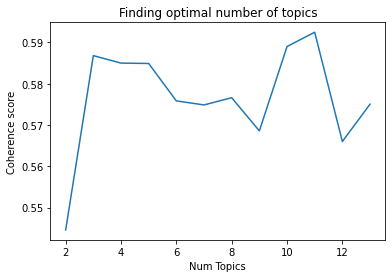

In [89]:
# Show graph
limit=14; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Finding optimal number of topics')
plt.savefig('coherence19feb.png')
plt.show()

In [90]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5446
Num Topics = 3  has Coherence Value of 0.5868
Num Topics = 4  has Coherence Value of 0.585
Num Topics = 5  has Coherence Value of 0.5849
Num Topics = 6  has Coherence Value of 0.5758
Num Topics = 7  has Coherence Value of 0.5749
Num Topics = 8  has Coherence Value of 0.5766
Num Topics = 9  has Coherence Value of 0.5686
Num Topics = 10  has Coherence Value of 0.589
Num Topics = 11  has Coherence Value of 0.5925
Num Topics = 12  has Coherence Value of 0.566
Num Topics = 13  has Coherence Value of 0.575


We choose the maximum coherence (11), but we also explore other numbers.

In [101]:
# Select the model and print the topics
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=15))


[(0,
  '0.107*"tonight" + 0.066*"love" + 0.061*"late" + 0.042*"great" + 0.042*"day" '
  '+ 0.042*"thing" + 0.028*"world" + 0.027*"chat" + 0.017*"documentary" + '
  '0.017*"big_night" + 0.016*"spend" + 0.015*"outage" + 0.014*"cool" + '
  '0.014*"thereidout" + 0.012*"hear"'),
 (1,
  '0.339*"film" + 0.053*"music" + 0.051*"project" + 0.049*"currently_looke" + '
  '0.049*"game_animation" + 0.045*"gl" + 0.013*"visit_http" + '
  '0.013*"rainsdowne_players" + 0.008*"poster" + 0.008*"thenew" + '
  '0.008*"literally" + 0.008*"artist" + 0.007*"surprise" + 0.007*"hire" + '
  '0.007*"light"'),
 (2,
  '0.058*"join" + 0.051*"good" + 0.038*"year" + 0.022*"set" + 0.022*"lot" + '
  '0.021*"bad" + 0.020*"movie" + 0.020*"remake" + 0.017*"put" + 0.016*"boy" + '
  '0.015*"franchise" + 0.015*"stuff" + 0.015*"forget" + 0.014*"speak" + '
  '0.012*"icymi"'),
 (3,
  '0.169*"podcast" + 0.081*"time" + 0.071*"listen" + 0.042*"discuss" + '
  '0.041*"work" + 0.031*"stream" + 0.024*"character" + 0.020*"end" + '
  '0.0

In [94]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.59246495877583


# Study model (from the lab)

## Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The _format_topics_sentences()_ function below nicely aggregates this information in a presentable table.

In [97]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic[['Keywords','Text']].head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Keywords,Text
0,"wandavision, release, spoiler, wanda_thevision, impact, word, amazing, reveal, power, hope",RT WARNING - SPOILERS BELOW: A brief frame during #WandaVision's new episode offered more insight into #SWORD's plan with #Th…
1,"tonight, love, late, great, day, thing, world, chat, big_night, documentary",RT New JJK episode had me sketching 😼
2,"watch, live, favorite, genre, bobcore, share, feel, tweet, honor, song",#107DaysOfGenocide since joint forces of the #Ethiopian &amp; #Eritrean gov’ts started to exterminate ethnic Tigrayans…
3,"tonight, love, late, great, day, thing, world, chat, big_night, documentary","RT The new documentary about the late, great Patrice O’Neal premieres tonight on Comedy Central. We went over some of his lesson…"
4,"tonight, love, late, great, day, thing, world, chat, big_night, documentary",RT ALSO NEW EPISODE OF THE BOAT SHOW
5,"wandavision, release, spoiler, wanda_thevision, impact, word, amazing, reveal, power, hope",RT Edward is the first Southern white rhino to be born via artificial insemination in North America at the It'…
6,"wandavision, release, spoiler, wanda_thevision, impact, word, amazing, reveal, power, hope","RT #wandavision #MonicaRambeau new episode 7 spoilers , the way carol’s words had such a long lasting impact on monica and help…"
7,"tonight, love, late, great, day, thing, world, chat, big_night, documentary","RT The new documentary about the late, great Patrice O’Neal premieres tonight on Comedy Central. We went over some of his le…"
8,"tonight, love, late, great, day, thing, world, chat, big_night, documentary","i hope she’s in the new captain marvel movie too, that would be so cool she’s a really cool character"
9,"movie, make, trailer, video, guest, uhg, skydance, cover, special, trustmovie",RT #TheHardyBoys go under cover at a New England college where three coeds have been kidnapped when #ValerieBertinelli guest…


## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [96]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf_mallet.head(12)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2424,"tonight, love, late, great, day, thing, world, chat, big_night, documentary","RT The new documentary about the late, great Patrice O’Neal premieres tonight on Comedy Central. We went over some of his lesson…"
1,1.0,0.2026,"film, music, project, currently_looke, game_animation, gl, rainsdowne_players, visit_http, literally, poster","Currently looking for new game, animation, and film 🎵 projects! Check out my music in The Rainsdowne Players! Visit…"
2,2.0,0.2163,"join, good, year, set, lot, bad, movie, remake, put, boy",RT another piece on celebrating his 10 year anniversary put together by and I speak a lil bit abou…
3,3.0,0.1991,"podcast, time, listen, discuss, work, stream, character, end, finally, issue",RT Leftists have been burned many times by Hollywood depictions—so it’s a welcome surprise when mainstream filmmakers actually…
4,4.0,0.2026,"watch, live, favorite, genre, bobcore, share, feel, tweet, honor, song","RT as a person who is totally still afraid of the dark, it’s an honor to share that my song “around your room” is in a new…"
5,5.0,0.1705,"show, young, supergirl, dc_universe, original, pick, season, tomorrow, full, tune","RT PLANET LOCKDOWN: DR CARRIE MADEJ FULL INTERVIEW Dr. Carrie Madej - one hour interview, part of full-le…"
6,6.0,0.1883,"wandavision, release, spoiler, wanda_thevision, impact, word, amazing, reveal, power, hope","RT #wandavision #wandavision10s new episode 7 spoilers , MONICA RAMBEAU’S EYES GLOW YUP SHE’S IN THE MOST POWERFUL AVENGERS CAT…"
7,7.0,0.1883,"movie, make, trailer, video, guest, uhg, skydance, cover, special, trustmovie","I don’t remember much but like I remember it was awesome. Recreating a movie isn’t really just recreating,…"
8,8.0,0.2548,"brand, today, feature, back, drop, friend, send, people, long, link",RT Lost about 20 friends/nursed 2. No health insurance. Relationships decades long had to break up. People had to go back hom…
9,9.0,0.2163,"talk, accountability, terrify, republicans_complain, find, life, big, night, start, play",RT ‘I’m fed up with some of the old labels ... I’m fed up being described in simplistic terms that do not capture the compl…
